In [243]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import math
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [244]:
#
df = pd.read_csv('/content/META.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-05-01,238.619995,244.000000,236.460007,243.179993,242.922241,29143900
1,2023-05-02,243.179993,244.919998,238.990005,239.240005,238.986435,24350100
2,2023-05-03,239.470001,241.750000,232.750000,237.029999,236.778778,34463900
3,2023-05-04,236.059998,238.199997,232.929993,233.520004,233.272491,17889400
4,2023-05-05,232.240005,234.679993,229.850006,232.779999,232.533279,26978900
...,...,...,...,...,...,...,...
246,2024-04-23,491.250000,498.760010,488.970001,496.100006,496.100006,15079200
247,2024-04-24,508.059998,510.000000,484.579987,493.500000,493.500000,37772700
248,2024-04-25,421.399994,445.769989,414.500000,441.380005,441.380005,82890700
249,2024-04-26,441.459991,446.440002,431.959991,443.290009,443.290009,31925900


2. Plot the prices for the given data.

In [245]:
df1 = df['Adj Close']

([<matplotlib.axis.XTick at 0x7b8759f9a3e0>], [Text(251.0, 0, 'off')])

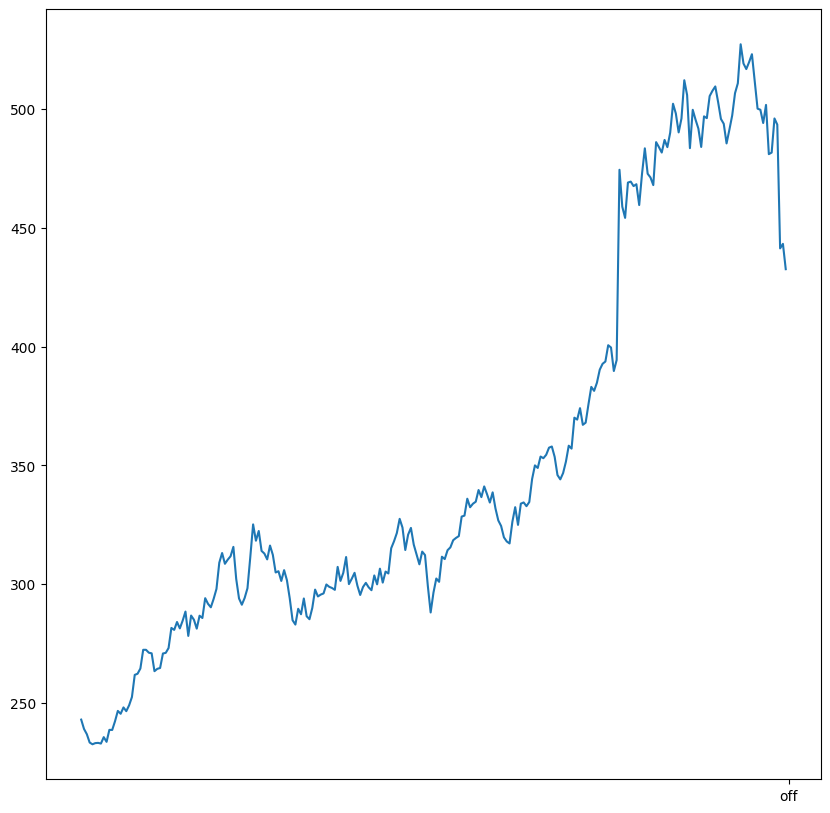

In [246]:
plt.figure(figsize=(10,10))
plt.plot(df['Date'],df['Adj Close'])
plt.xticks("off")

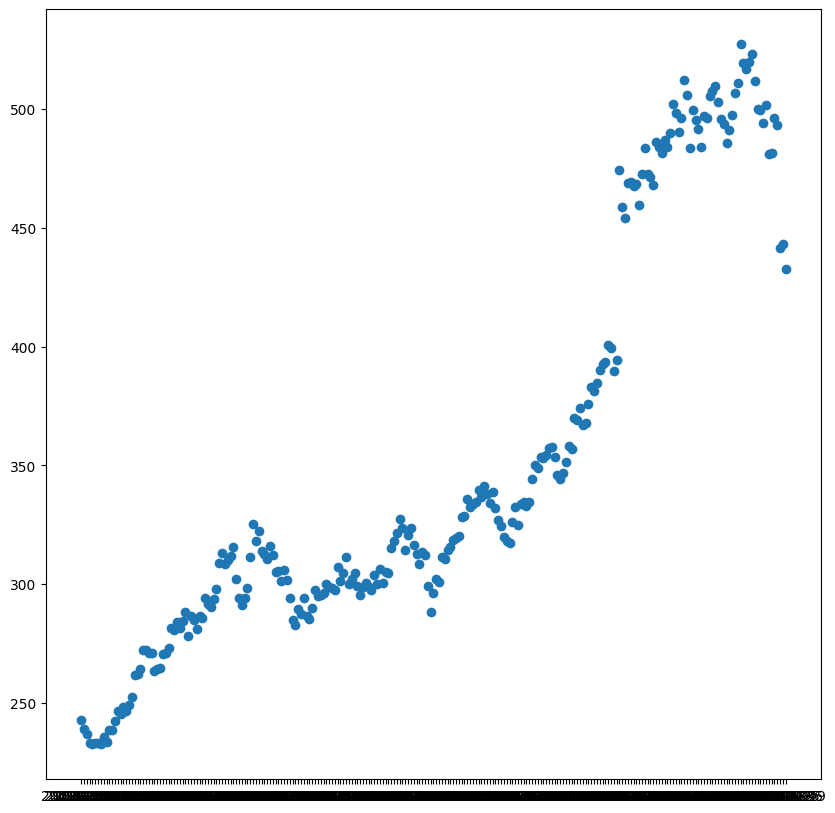

In [247]:
plt.scatter(df['Date'],df['Adj Close'])
plt.show()

3. Plot log-returns for the given data.

In [248]:
#log returns

log_pr=np.log(df1)
log_ret=log_pr.diff()
log_ret

0           NaN
1     -0.016335
2     -0.009281
3     -0.014919
4     -0.003174
         ...   
246    0.029394
247   -0.005255
248   -0.111617
249    0.004318
250   -0.024364
Name: Adj Close, Length: 251, dtype: float64

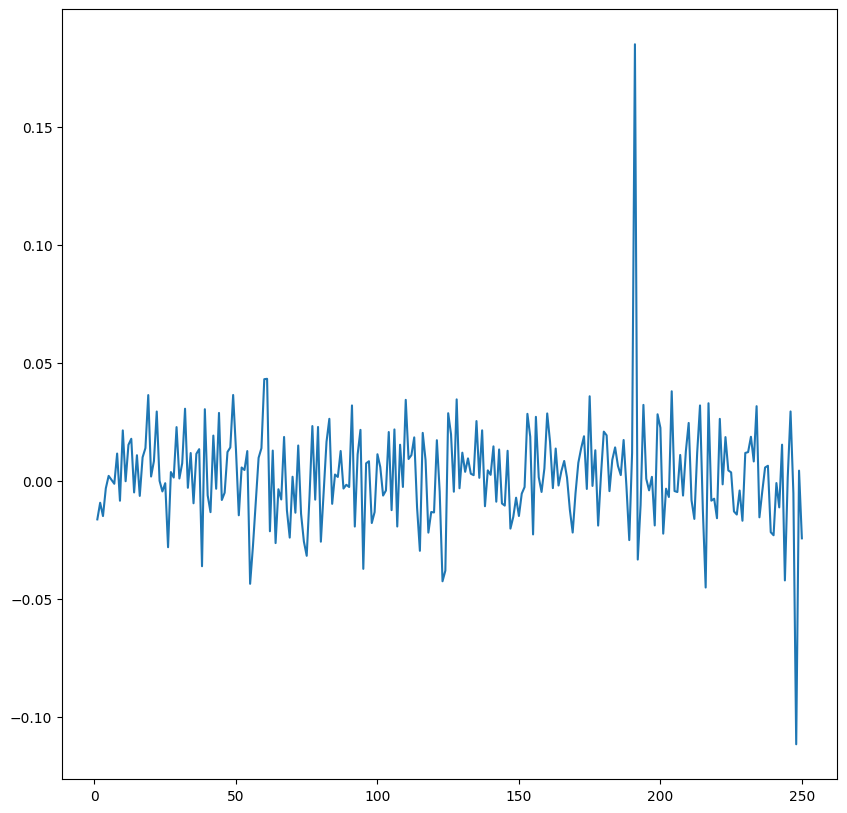

In [249]:
plt.plot(log_ret)

In [250]:
from matplotlib import pyplot
#Printing mean and sts dev of log returns
print('mean=%.3f stdv=%.3f' % (np.mean(log_ret), np.std(log_ret)))

mean=0.002 stdv=0.022


4. Normality Checks

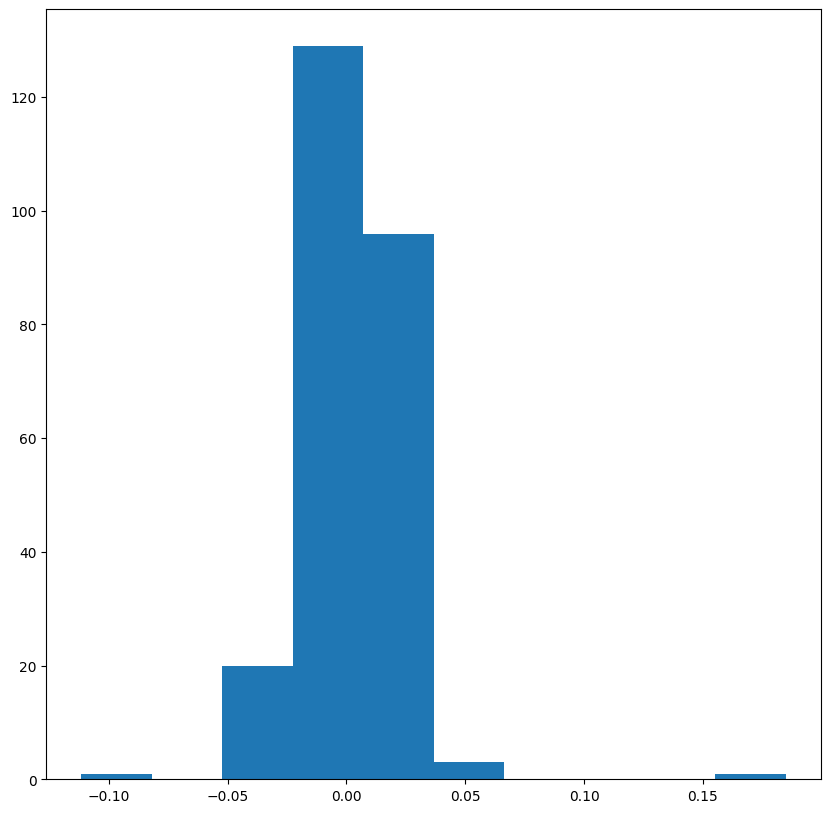

In [251]:
#histogram
from matplotlib import pyplot

pyplot.hist(log_ret)
pyplot.show()

In [252]:
log_ret[0]=0 #making all values finite
log_ret

0      0.000000
1     -0.016335
2     -0.009281
3     -0.014919
4     -0.003174
         ...   
246    0.029394
247   -0.005255
248   -0.111617
249    0.004318
250   -0.024364
Name: Adj Close, Length: 251, dtype: float64

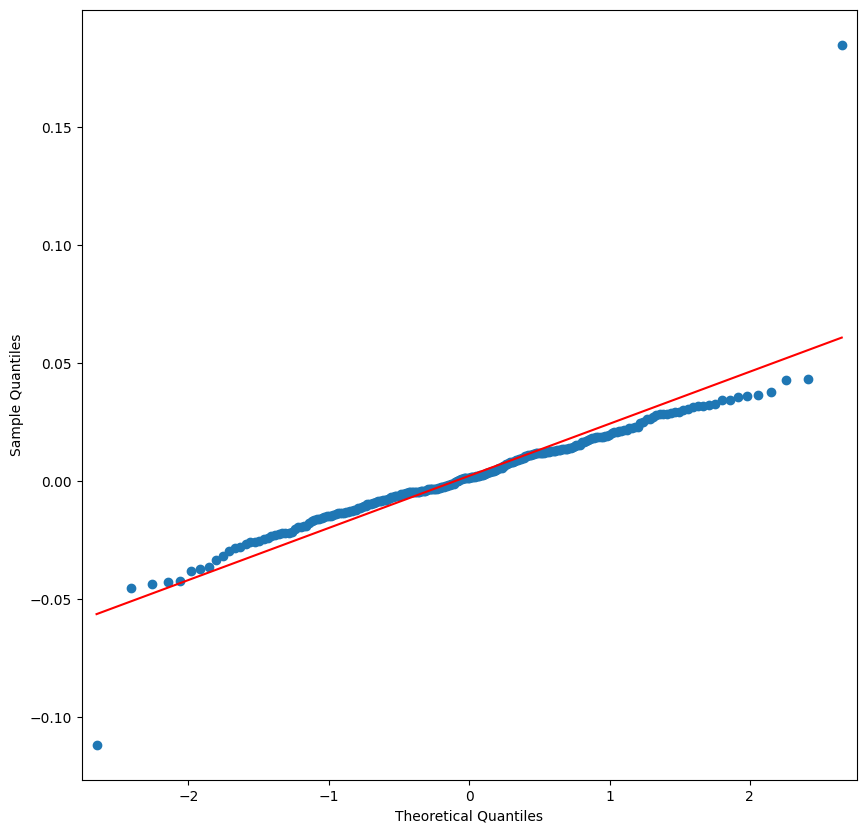

In [253]:
from statsmodels.graphics.gofplots import qqplot
qqplot(log_ret, line='s')
pyplot.show()

The data is not normally distributed because QQ plot is not straight and has significant deviation from the line.

In [254]:
import scipy.stats as stats
stat,p=stats.jarque_bera(log_ret)
print('Statistics=%f, p=%f' % (stat, p))
alpha=0.05
if p < alpha:
  print("Null hypothesis can be rejected, it is not normally distributed")
else:
  print("Null hypothesis cannot be rejected, it is normally distributed")

Statistics=4146.669119, p=0.000000
Null hypothesis can be rejected, it is not normally distributed


Since the p-value is less than 0.05 we can reject the null hypothesis and we can say that the data is not normally distributed. It has skewness and kurtosis significantly different from a normal distribution.

In [255]:
#Kolmogorov-Smirnov test
stats.kstest(log_ret, 'norm')

KstestResult(statistic=0.4787758960506857, pvalue=2.0414602676973201e-53, statistic_location=0.04322783137383279, statistic_sign=1)

Since the p-value is less than 0.05 we say that the log returns are not normally distributed

In [256]:
#D’Agostino’s K-squared test
from scipy.stats import normaltest

stat, p = normaltest(log_ret)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
# H0 = The data is noramlly distributed
if p > alpha:
	print('Sample seems to be Guassian (fail to reject H0)')
else:
	print('Sample does not seem to be Gaussian (reject H0)')

Statistics=141.400, p=0.000
Sample does not seem to be Gaussian (reject H0)


5. Estimate the historical volatility using log returns.

In [257]:
vol=log_ret.std()
vol

0.022111640464926325

In [258]:
vol_annual = np.sqrt(252)*vol
vol_annual

0.3510114104992061

6. Identify the risk free rate for the given currency

In [259]:
# https://ycharts.com/indicators/3_month_t_bill
# Current Risk Free Interest Rate for 3 month Treasury is 5.25%
rff = 0.0525

7. Test the assumption if the log-returns are independent/uncorrelated.

In [260]:
logr = pd.DataFrame(np.array(log_ret),columns=['log_ret'])
print(logr)

      log_ret
0    0.000000
1   -0.016335
2   -0.009281
3   -0.014919
4   -0.003174
..        ...
246  0.029394
247 -0.005255
248 -0.111617
249  0.004318
250 -0.024364

[251 rows x 1 columns]


In [261]:
logr["lag_1"] = logr["log_ret"].shift(periods=1)
logr

,log_ret,lag_1
0,0.000000,NaN
1,-0.016335,0.000000
2,-0.009281,-0.016335
3,-0.014919,-0.009281
4,-0.003174,-0.014919
...,...,...
246,0.029394,0.001371
247,-0.005255,0.029394
248,-0.111617,-0.005255
249,0.004318,-0.111617


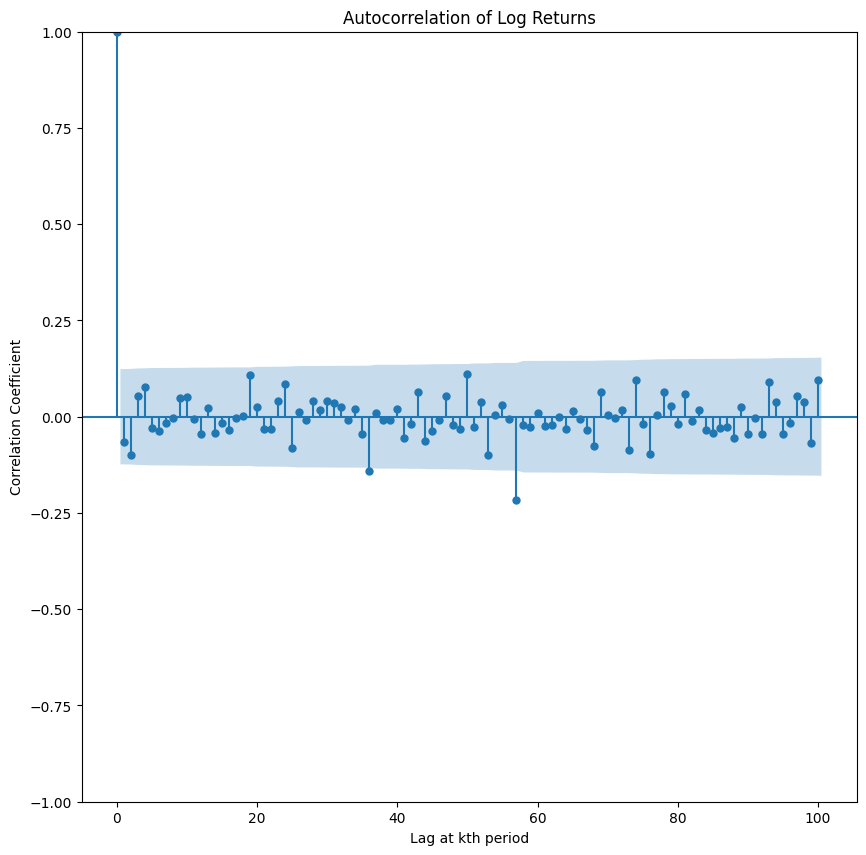

In [262]:
from statsmodels.graphics import tsaplots

plt.rc("figure",figsize=(10,10))

fig = tsaplots.plot_acf(logr["log_ret"], lags=100)

plt.title("Autocorrelation of Log Returns")
plt.xlabel("Lag at kth period")
plt.ylabel("Correlation Coefficient")
plt.show()

From graph, we can see that the log returns are independent/uncorrelated as the correlation coefficient is very low (Less than 0.5)

8,9 (i) The option price for an In-The-Money (ITM) European call option using CRR, Black-Scholes and Simulation Methods

In [263]:
def nCr(n,r):
  f = math.factorial
  return f(n) / f(r) / f(n-r)

class OptionCallCRR():
  """
  This function find the call option price under CRR Model.
  """
  def __init__(self, s0, sigma, strike, maturity, rfr, n, dyield = None):
    '''
    s0: initial equity price, sigma: volatility, rfr: risk free rate, n: number
    '''
    self.s0 = s0
    self.sigma = sigma
    self.rfr = rfr
    self.maturity = maturity
    self.strike = strike
    self.n = n
    self.dyield = dyield
  def price(self):
    delta = float(self.maturity)/float(self.n)
    u = math.exp(self.sigma*math.sqrt(delta))
    d = 1/math.exp(self.sigma*math.sqrt(delta))
    if self.dyield == None:
      q = (math.exp(self.rfr*delta) - d) / (u - d)

    else:
      q = (math.exp((self.rfr-self.dyield)*delta) - d) / (u - d)
    prc = 0
    temp_stock = 0
    temp_payout = 0
    for x in range(0, self.n + 1):
      temp_stock = self.s0*((u)**(x))*((d)**(self.n - x))
      temp_payout = max(temp_stock - self.strike, 0)
      prc += nCr(self.n, x)*(q**(x))*((1-q)**(self.n - x))*temp_payout
    prc = prc / ((1+ self.rfr*delta )**self.n)
    #prc = prc / math.exp(self.rfr*delta)
    return prc

class OptionPutCRR():
  """
  This function find the put option price under CRR Model.
  """
  def __init__(self, s0, sigma, strike, maturity, rfr, n, dyield = None):
    '''
    s0: initial equity price, sigma: volatility, rfr: risk free rate, n: number
    '''
    self.s0 = s0
    self.sigma = sigma
    self.rfr = rfr
    self.maturity = maturity
    self.strike = strike
    self.n = n
    self.dyield = dyield
  def price(self):
    delta = float(self.maturity)/float(self.n)
    u = math.exp(self.sigma*math.sqrt(delta))
    d = 1/math.exp(self.sigma*math.sqrt(delta))
    if self.dyield == None:
      q = (math.exp(self.rfr*delta) - d) / (u - d)

    else:
      q = (math.exp((self.rfr-self.dyield)*delta) - d) / (u - d)
    prc = 0
    temp_stock = 0
    temp_payout = 0
    for x in range(0, self.n + 1):
      temp_stock = self.s0*((u)**(x))*((d)**(self.n - x))
      temp_payout = max(self.strike - temp_stock, 0)
      prc += nCr(self.n, x)*(q**(x))*((1-q)**(self.n - x))*temp_payout
    prc = prc / ((1+ self.rfr*delta )**self.n)
    #prc = prc / math.exp(self.rfr*delta)
    return prc

In [264]:
S0 = 432.62
strikeCall = 430
strikePut = 435
cr1 = OptionCallCRR(432.62, vol_annual, strikeCall, 31/365.0, 0.0525, 100)
cr2 = OptionCallCRR(432.62, vol_annual, strikePut, 31/365.0, 0.0525, 100)
# (cr)

In [265]:
print("call option price = " , cr1.price())
print("put option price = " , cr2.price())

call option price =  19.94342064044947
put option price =  17.460007090591642


9.  Black-Scholes and Simulation Methods to compute the call/put option prices.

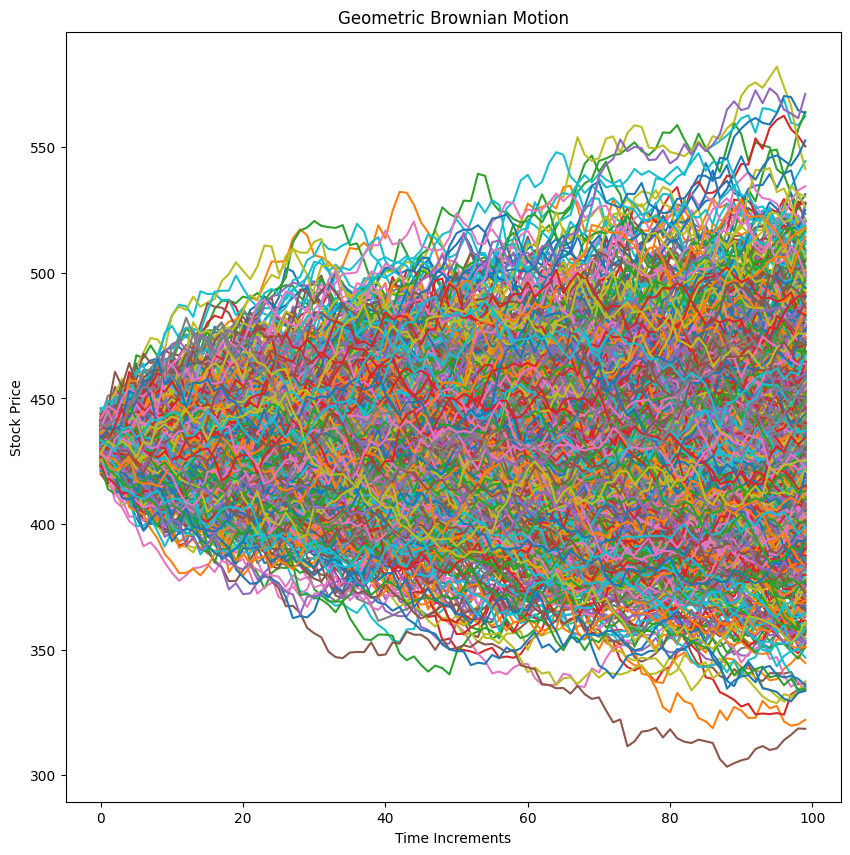

In [266]:
import numpy as np
import matplotlib.pyplot as plt
def GBM_paths(S, T, r, q, sigma, steps, N):
  """
  Inputs
  #S = Current stock Price
  #K = Strike Price
  #T = Time to maturity 1 year = 1, 1 months = 1/12
  #r = risk free interest rate
  #q = dividend yield
  # sigma = volatility
  Output
  # [steps,N] Matrix of asset paths
  """
  # S(t) = S(0)*exp(mu-sigm**2/2)+ sigma*B(t) GBM.
  dt = T/steps
  ST = np.log(S) + np.cumsum(((r - q - sigma**2/2)*dt +\
  sigma*np.sqrt(dt) * \
  np.random.normal(size=(steps,N))),axis=0)
  return np.exp(ST)

S = 432.62 # stock price S_{0}
T = 31/365.0 # time to maturity
r = 0.0525 # risk free risk in annual %
q = 0 # annual dividend rate = N/A
sigma = vol_annual # annual volatility in %
steps = 100 # time steps
N = 1000 # number of trials
paths = GBM_paths(S,T,r,q,sigma,steps,N)
plt.plot(paths);
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion")
plt.show()

In [267]:
from numpy.linalg import norm
from scipy.stats import norm
def black_scholes_call(S,K,T,r,q,sigma):
  """
  Inputs
  # S = Current stock Price
  # K = Strike Price
  # T = Time to maturity 1 year = 1, 1 months = 1/12
  # r = risk free interest rate
  # q = dividend yield
  # sigma = volatility
  Output
  # call_price = value of the option
  """
  d1 = (np.log(S/K) + (r - q + sigma**2/2)*T) / sigma*np.sqrt(T)
  d2 = d1 - sigma* np.sqrt(T)
  call = S * np.exp(-q*T)* norm.cdf(d1) - K * np.exp(-r*T)*norm.cdf(d2)
  return call
def black_scholes_put(S,K,T,r,q,sigma):
  """
  Inputs
  # S = Current stock Price
  # K = Strike Price
  # T = Time to maturity 1 year = 1, 1 months = 1/12
  # r = risk free interest rate
  # q = dividend yield
  # sigma = volatility
  Output
  # put_price = value of the option
  """
  d1 = (np.log(S/K) + (r - q + sigma**2/2)*T) / sigma*np.sqrt(T)
  d2 = d1 - sigma* np.sqrt(T)
  put = K * np.exp(-r*T)*norm.cdf(-d2) - S * np.exp(-q*T)* norm.cdf(-d1)
  return put


#Simulated option price(call)
K = strikeCall
payoffs = np.maximum(paths[-1]-K, 0)
option_price_call = np.mean(payoffs)*np.exp(-r*T) #discounting
bs_price_call = black_scholes_call(S,K,T,r,q,sigma)
print(f"Black Scholes call Price is {bs_price_call}")
print(f"Simulated call price is {option_price_call}")

K = strikePut

payoffs = np.maximum(K-paths[-1], 0)
option_price_put = np.mean(payoffs)*np.exp(-r*T) #discounting
bs_price_put = black_scholes_put(S,K,T,r,q,sigma)
print(f"Black Scholes put Price is {bs_price_put}")
print(f"Simulated put price is {option_price_put}")

Black Scholes call Price is 19.740148432175317
Simulated call price is 18.137624042994073
Black Scholes put Price is 17.867327747520022
Simulated put price is 18.497977954727762


10. Other method to estimate the volatility parameter
other than the historical volatility

In [268]:
!pip install mibian

In [269]:
import mibian

## BS([UnderlyingPrice, StrikePrice, InterestRate, Daystoexpiration],callPrice=x)

ans=mibian.BS([S0, K, 0.0083,36],callPrice= bs_price_put)
ans.impliedVolatility

35.03406047821045

In [270]:
!pip install arch

In [271]:
from arch import arch_model

test_days = 30
train, test = log_ret[:-test_days], log_ret[-test_days:]
model = arch_model(train, mean='Zero', vol='GARCH', p=1, q=1)

fitted_model = model.fit()
fi = fitted_model.forecast(horizon=test_days)

Iteration:      1,   Func. Count:      5,   Neg. LLF: -474.72782068483014
Iteration:      2,   Func. Count:     10,   Neg. LLF: -470.36475868111165
Iteration:      3,   Func. Count:     15,   Neg. LLF: -470.36475868111165
Iteration:      4,   Func. Count:     20,   Neg. LLF: -470.36475868111165
Iteration:      5,   Func. Count:     24,   Neg. LLF: -535.8833162293772
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -535.8833145344305
            Iterations: 5
            Function evaluations: 24
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004548. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [272]:
print(np.sqrt(fi.variance.values[-1, :]))

[0.02203427 0.02200311 0.02197397 0.0219467  0.02192119 0.02189732
 0.021875   0.02185412 0.02183459 0.02181633 0.02179925 0.02178328
 0.02176835 0.02175439 0.02174134 0.02172913 0.02171772 0.02170705
 0.02169708 0.02168776 0.02167905 0.0216709  0.02166329 0.02165617
 0.02164952 0.0216433  0.02163749 0.02163206 0.02162698 0.02162224]


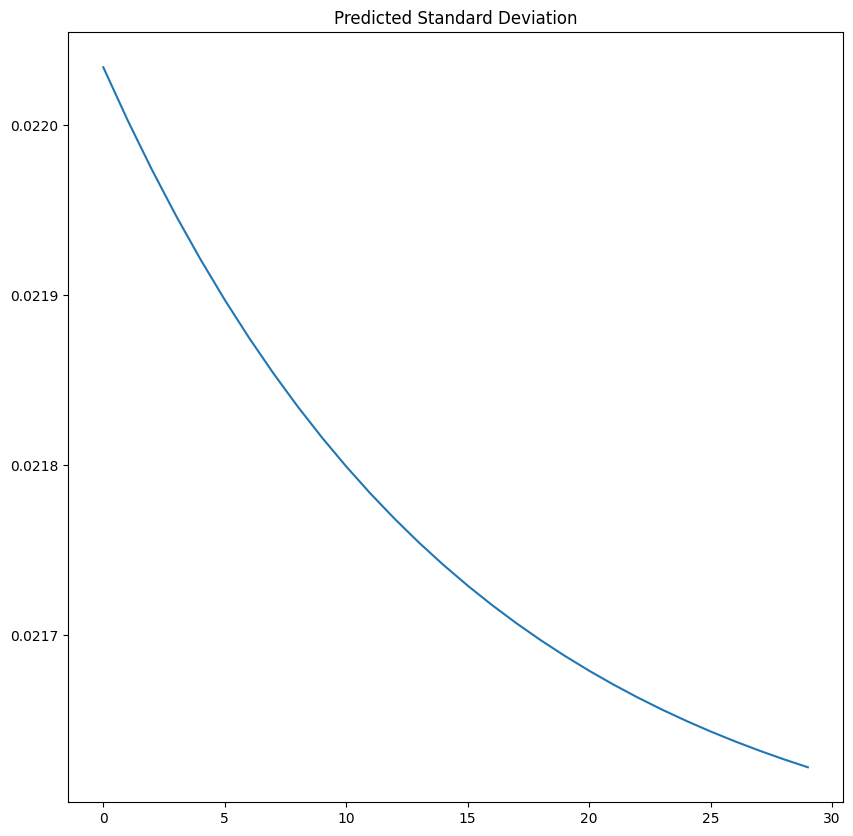

In [273]:
plt.plot(np.sqrt(fi.variance.values[-1, :]))
plt.title("Predicted Standard Deviation")
plt.show()

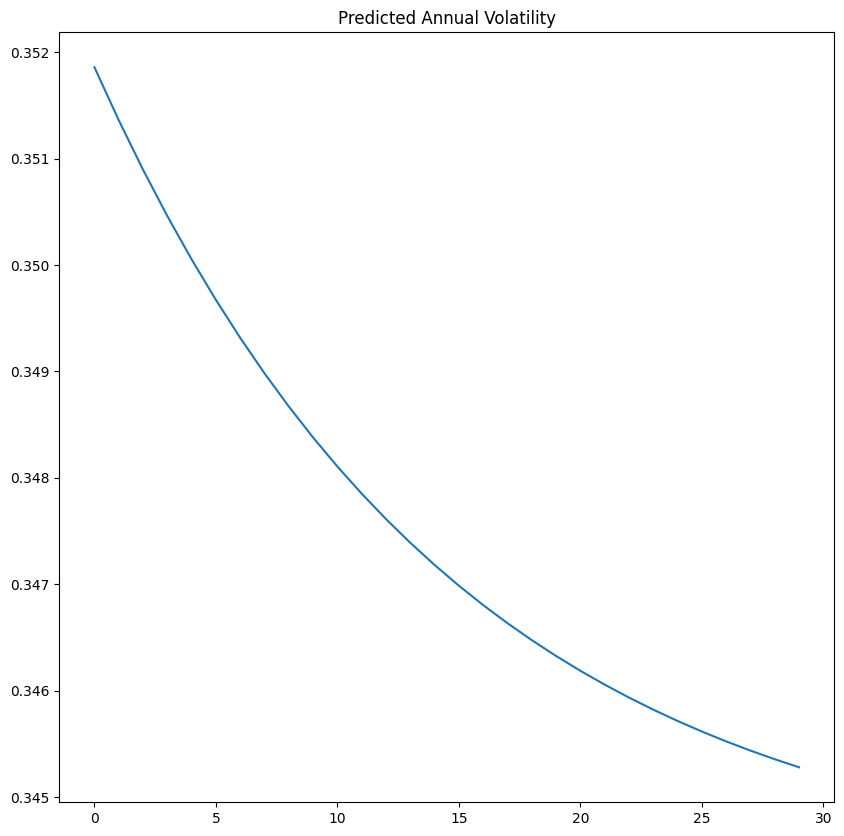

In [274]:
plt.plot(np.sqrt(255*fi.variance.values[-1, :]))
plt.title("Predicted Annual Volatility")
plt.show()

In [275]:
np.sqrt(255*fi.variance.values[-1, :])

array([0.351859  , 0.35136156, 0.35089612, 0.35046065, 0.35005326,
       0.34967217, 0.34931571, 0.3489823 , 0.34867048, 0.34837887,
       0.34810616, 0.34785115, 0.3476127 , 0.34738975, 0.3471813 ,
       0.3469864 , 0.3468042 , 0.34663386, 0.34647462, 0.34632576,
       0.34618661, 0.34605654, 0.34593496, 0.34582131, 0.34571509,
       0.34561581, 0.34552301, 0.34543628, 0.34535522, 0.34527946])

Here the annual volatility has been calculated using the GARCH model. It predicts variance which is used in the calculation of standard deviation followed by Volatility.

Historical Volatility = 0.02162224

Annual Historical Volatility = 0.34527946


---
---


Volatility estimation using GARCH model (time-series volatility) = in the range [0.02570, 0.02620] = approx 0.0258

Annual Volatility estimation using GARCH model = in the range [0.418, 0.413] = approx 0.414

Hence, for this 30-day test period the results are very similar.

In [280]:
vol_garch = 0.02162224
vol_annual_garch = 0.34527946
sigma_garch = vol_annual_garch

Put and call option prices using vol_garch and vol_annual_garch

In [281]:
# using CRR
crr_call_garch = OptionCallCRR(432.62, vol_annual_garch, strikeCall, 31/365.0, 0.0525, 100)
crr_put_garch = OptionCallCRR(432.62, vol_annual_garch, strikePut, 31/365.0, 0.0525, 100)

# using Black scholes and simulation
K = strikeCall
payoffs = np.maximum(paths[-1]-K, 0)
option_price_call_garch = np.mean(payoffs)*np.exp(-r*T) #discounting
bs_price_call_garch = black_scholes_call(S,K,T,r,q,sigma_garch)


K = strikePut

payoffs = np.maximum(K-paths[-1], 0)
option_price_put_garch = np.mean(payoffs)*np.exp(-r*T) #discounting
bs_price_put_garch = black_scholes_put(S,K,T,r,q,sigma_garch)


In [282]:
print("CRR call option price using estimated Volatility = " , crr_call_garch.price())
print("CRR put option price using estimated Volatility = " , crr_put_garch.price())
print(f"Black Scholes call Price using estimated Volatility {bs_price_call_garch}")
print(f"Simulated call price using estimated Volatility {option_price_call_garch}")
print(f"Black Scholes put Price using estimated Volatility {bs_price_put_garch}")
print(f"Simulated put price using estimated Volatility {option_price_put_garch}")

CRR call option price using estimated Volatility =  19.658739770617395
CRR put option price using estimated Volatility =  17.17223830131731
Black Scholes call Price using estimated Volatility 19.45615687807333
Simulated call price using estimated Volatility 18.137624042994073
Black Scholes put Price using estimated Volatility 17.58005314823427
Simulated put price using estimated Volatility 18.497977954727762


In [283]:
CRR_Value = [cr1.price(),crr_call_garch.price(),cr2.price(),crr_put_garch.price()]
Simulation_Value = [option_price_call,option_price_call_garch,option_price_put,option_price_put_garch]
Black_Schole_Value=[bs_price_call,bs_price_call_garch,bs_price_put,bs_price_put_garch]
data = {'Option Value Using CRR Model': CRR_Value,
 'Option Value Using Simulation': Simulation_Value,
 'Option Value Using Black Scholes Model':Black_Schole_Value}
# Creates pandas DataFrame
df = pd.DataFrame(data, index =['Call Option with Historical Volatility','Call Option with Garch Volatility','Put Option with Historical Volatility','Put Option with Garch Volatility'])
df

,Option Value Using CRR Model,Option Value Using Simulation,Option Value Using Black Scholes Model
Call Option with Historical Volatility,19.943421,18.137624,19.740148
Call Option with Garch Volatility,19.658740,18.137624,19.456157
Put Option with Historical Volatility,17.460007,18.497978,17.867328
Put Option with Garch Volatility,17.172238,18.497978,17.580053
